# Sad songs<a name="top"></a>

This is a replication of the [fitteR happieR](http://rcharlie.com/2017-02-16-fitteR-happieR/) post which attempted to find the most depressing Radiohead song.

I've redone it here, using tools available in TM351.

I'm also on a bit of a Beatles jag, so I've also done the analysis for Beatles songs.

http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0115255#s5
https://www.discogs.com/developers/#page:database,header:database-artist-releases
http://data.discogs.com/


Also look at [How to make a racist AI without really trying](https://gist.github.com/rspeer/ef750e7e407e04894cb3b78a82d66aed), which has some good links for sentiment analysis.


## Contents: Data analysis
* [Analysis](#analysis)
* [Sentiment](#sentiment)
* [Gloom index](#gloomindex)
* [Revised gloom index](#revisedgloomindex)
* [Contrasting songs](#valencenegcontrast)
* [Gloom per album](#gloomperalbum)
* [Complexity per album](#complexityovertime)

### [Conclusion](#conclusion)

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import urllib.request
import urllib.parse
import urllib.error
import json
import base64
import configparser
from bs4 import BeautifulSoup
import re
import pymongo
from datetime import datetime
import time
import collections
import editdistance

We'll use MongoDB to store the data, to save keeping it all in memory, and mean we don't have to recapture all the data to to a different analysis.

In [2]:
# Open a connection to the Mongo server
client = pymongo.MongoClient('mongodb://localhost:27017/')

In [3]:
# Create a database and a collections within it.
songs_db = client.songs
albums = songs_db.albums
tracks = songs_db.tracks
genius_tracks = songs_db.gtracks

API keys and the like are kept in a configuration file, which is read here.

You'll need to create a web API key for Spotify and Genius. 

In [4]:
config = configparser.ConfigParser()
config.read('secrets.ini')
[k for k in config['genius']]

['app_name', 'client_id', 'client_secret', 'redirect_uri', 'token']

In [6]:
## How to write the config file. Fill in the details, and create a different config section for Spotify.
# config['genius'] = {}
# config['genius']['app_name'] = 'xxx'
# config['genius']['client_id'] = 'xxx'
# config['genius']['client_secret'] = 'xxx'
# config['genius']['token'] = 'xxx'
# with open('secrets.ini', 'w') as configfile:
#     config.write(configfile)

In [13]:
stones_id = '22bE4uQ6baNwSHPVcDxLCe'
beatles_id = '3WrFJ7ztbogyGnTHbHJFl2'
radiohead_id = '4Z8W4fKeB5YxbusRsdQVPb'

In [10]:
radiohead_id = albums.find_one({'artist_name': 'Radiohead'})['artist_id']
radiohead_id

'4Z8W4fKeB5YxbusRsdQVPb'

In [11]:
beatles_id = albums.find_one({'artist_name': 'The Beatles'})['artist_id']
beatles_id

'3WrFJ7ztbogyGnTHbHJFl2'

In [12]:
stones_id = albums.find_one({'artist_name': 'The Rolling Stones'})['artist_id']
stones_id

'22bE4uQ6baNwSHPVcDxLCe'

# Analysis<a name="analysis"></a>
Finally, we can get to the analysis of the data!

First, what are the lowest-valence songs, and what's the distribution of valences?

* [Top](#top)

In [14]:
pd.DataFrame(list(tracks.find({}, 
                              ['artist_name', 'name', 'valence'], 
                              sort=[('valence', pymongo.ASCENDING)], limit=20)))

,_id,artist_name,name,valence
0,2l4gWzhTj7Yt1IvMTWnSgF,The Rolling Stones,Martin Scorsese Intro - Live At The Beacon The...,NaN
1,0y2gwbLt4rT57AqVWanxrS,The Rolling Stones,Show Intro - Live In Ireland / 1965,NaN
2,1AVrv7FD10FoKW38oBiKRg,Radiohead,Bloom (Blawan Rmx),0.0325
3,2Ax0tajnMzn8bB0jkmGNCK,The Rolling Stones,Band Introductions - Live At The Beacon Theatr...,0.0351
4,4rkGGQEqxHIXVJ4oXjOHgF,George Martin,Sea Of Holes - Remastered 2009,0.0352
5,1n2pCKUiJW7hxFUpbsjuUZ,The Rolling Stones,Charlie's Intro To Little Red Rooster - Live I...,0.0357
6,6HazgW4PjOxihpQPAAnLya,Jimi Hendrix,Outro - Star Spangled Banner - Live - 2009 Re-...,0.0367
7,01ZpFhrMMqKPVCwyqXneVp,Radiohead,True Love Waits,0.0378
8,53RYTfkLiyZuUZHwJC3Wmm,Radiohead,We Suck Young Blood,0.0378
9,0ttMfoND7IQqFSMVOPkELC,The Beatles,Blue Jay Way - Remastered 2009,0.0380


Just the Beatles songs.

In [15]:
beatles_df = pd.DataFrame(list(tracks.find({'artist_id': beatles_id}, 
                              ['artist_name', 'name', 'valence'])))
beatles_df.sort_values('valence').head(10)

,_id,artist_name,name,valence
112,0ttMfoND7IQqFSMVOPkELC,The Beatles,Blue Jay Way - Remastered 2009,0.0380
146,0agoaPIy92gPZ6zRhqXarE,The Beatles,Tomorrow Never Knows - Remastered 2009,0.0556
108,6ZrPbHp9kRmQj1tGLvna8U,The Beatles,Revolution 9 - Remastered 2009,0.0963
103,27YZJHyTTDIurMqDu1v2ef,The Beatles,"Long, Long, Long - Remastered 2009",0.1350
0,2ucFulEWapRAmTn7l6f5Q7,The Beatles,Wild Honey Pie - Remastered 2009,0.1530
132,3ZFBeIyP41HhnALjxWy1pR,The Beatles,A Day In The Life - Remastered 2009,0.1620
65,4cLoL5KPfE1hAwfsO84FX7,The Beatles,Because - Remastered 2009,0.1620
43,7iABnSNZciNepqGtjMQxxd,The Beatles,Come Together - Remastered 2015,0.1780
58,0MKqeOVdZcUFGJvWpGCKbG,The Beatles,Come Together - Remastered 2009,0.1790
79,4gUUfLOH38XYU5Q3b2K4Go,The Beatles,It's All Too Much - Remastered 2009,0.1920


And plot the valences..

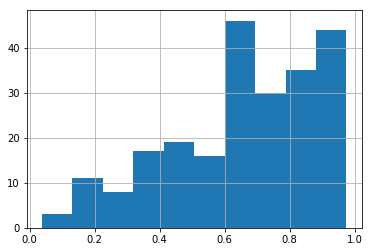

In [16]:
beatles_df['valence'].hist()

In [19]:
stones_df = pd.DataFrame(list(tracks.find({'artist_id': stones_id}, 
                              ['artist_name', 'name', 'valence'])))
stones_df.sort_values('valence').head(10)

,_id,artist_name,name,valence
6,2Ax0tajnMzn8bB0jkmGNCK,The Rolling Stones,Band Introductions - Live At The Beacon Theatr...,0.0351
12,1n2pCKUiJW7hxFUpbsjuUZ,The Rolling Stones,Charlie's Intro To Little Red Rooster - Live I...,0.0357
129,1dTX9ivyAhFJLR1f2pk9Kv,The Rolling Stones,Out Of Tears - 2009 Re-Mastered Digital Version,0.1280
138,6j3En9AD8FEAQQhhtkKBR9,The Rolling Stones,Continental Drift - Live - 2009 Re-Mastered Di...,0.1290
273,388ll2SEjDO9LZIXXyKtjh,The Rolling Stones,Little Rain,0.1370
109,1qEGxs60ntxuenj27BnRkF,The Rolling Stones,How Can I Stop - 2009 Digital Remaster,0.1690
106,1Wfdb6cNBPdpoZYniHfL7o,The Rolling Stones,Always Suffering - 2009 Digital Remaster,0.1740
234,7G6Z0sDe39MFjTaA0XfCtw,The Rolling Stones,I Can't Quit You Baby,0.1790
100,7tWJEqPI5Jpie3NhtbWks6,The Rolling Stones,Already Over Me - 2009 Digital Remaster,0.1790
83,07U5DnoRtB0DSlonXx2jym,The Rolling Stones,When The Whip Comes Down - Live Licks Tour - 2...,0.1820


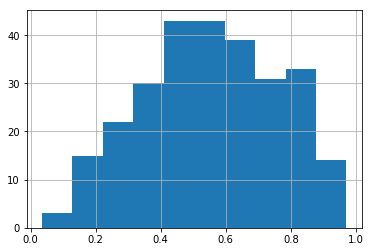

In [20]:
stones_df['valence'].hist()

In [17]:
radiohead_df = pd.DataFrame(list(tracks.find({'artist_id': radiohead_id}, 
                              ['artist_name', 'name', 'valence'])))
radiohead_df.sort_values('valence').head(10)

,_id,artist_name,name,valence
14,1AVrv7FD10FoKW38oBiKRg,Radiohead,Bloom (Blawan Rmx),0.0325
84,53RYTfkLiyZuUZHwJC3Wmm,Radiohead,We Suck Young Blood,0.0378
58,01ZpFhrMMqKPVCwyqXneVp,Radiohead,True Love Waits,0.0378
13,66Pyms4pYaHEcPHZ7DdMbE,Radiohead,TKOL (Altrice Rmx),0.0383
20,3gKuywOm38axM8sJGq6Laq,Radiohead,MK 1,0.0391
121,75YUnz58ajMo2VIIuUFvOV,Radiohead,The Tourist,0.0400
15,0tKuiKb2mazZYdA6fPP7kI,Radiohead,Good Evening Mrs Magpie (Modeselektor RMX),0.0413
109,0COiZ7ncho2yi4HotbzgPv,Radiohead,Motion Picture Soundtrack,0.0425
21,2uYSbsxAMmK1awUl06T7ix,Radiohead,MK 2,0.0437
70,4gq2bc2770XvbJdEtfUbmw,Radiohead,Go Slowly,0.0453


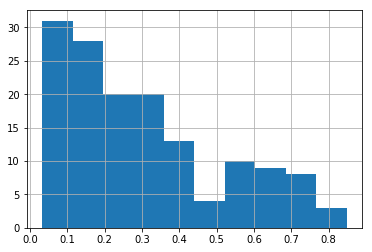

In [18]:
radiohead_df['valence'].hist()

And now plot both on the same chart, to clearly show that Radiohead songs are generally lower-valence than The Beatles.

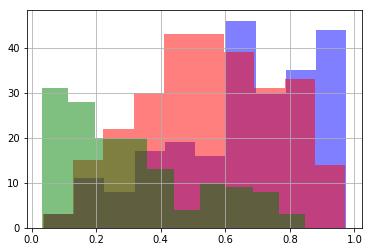

In [21]:
beatles_df['valence'].hist(alpha=0.5, color='blue')
stones_df['valence'].hist(alpha=0.5, color='red')
radiohead_df['valence'].hist(alpha=0.5, color='green')

### Sentiment<a name="sentiment"></a>
We can now look at the sentiment scores for the lyrics. We start by looking at the most negative songs for each artist.

* [Top](#top)

In [22]:
pipeline = [
    {'$match': {'lyrics': {'$exists': True}, 'sentiment': {'$exists': True}, 'valence': {'$exists': True},
               'artist_id': beatles_id}},
    {'$project': {'artist_name': '$artist_name',
                  'name': '$name',
                  'valence': '$valence',
                  'neg': '$sentiment.probability.neg',
                  'neutral': '$sentiment.probability.neutral',
                  'pos': '$sentiment.probability.pos'}}
]
beatles_df = pd.DataFrame(list(tracks.aggregate(pipeline)))
beatles_df.sort_values('neg', ascending=False).head(10)

,_id,artist_name,name,neg,neutral,pos,valence
87,3VgxeWOGdUYvtX1j8C9VyV,The Beatles,I'm So Tired - Remastered 2009,0.892489,0.146302,0.107511,0.6300
61,6gLmFcRwyQCQT23Df2Re9G,The Beatles,I Want You (She's So Heavy) - Remastered 2009,0.882642,0.091819,0.117358,0.4160
106,6ZrPbHp9kRmQj1tGLvna8U,The Beatles,Revolution 9 - Remastered 2009,0.873285,0.172322,0.126715,0.0963
185,3EbGioQyKyf4dycuiPOg3k,The Beatles,Everybody's Trying To Be My Baby - Remastered ...,0.866985,0.914332,0.133015,0.9370
16,79QDgDoBbS7pCrOjIH7ByA,The Beatles,Everybody’s Trying To Be My Baby - Live / Bonu...,0.866985,0.914332,0.133015,0.6390
52,4311wT21Et0q3vepFwXjTu,The Beatles,One After 909 - Remastered 2009,0.865737,0.158470,0.134263,0.9040
147,3QbhVaulXxTyuAxHY3Pa5N,The Beatles,You Won't See Me - Remastered 2009,0.864585,0.247226,0.135415,0.4620
194,3Aqo28W4LLAolYpN3duVJl,The Beatles,I'll Cry Instead - Remastered 2009,0.863772,0.160516,0.136228,0.9610
91,3OSi8ehmSWLTD5KatlzX8r,The Beatles,Don't Pass Me By - Remastered 2009,0.857831,0.120676,0.142169,0.9480
133,3wAOX1N5M0ta3QNsokmhJV,The Beatles,I'm Only Sleeping - Remastered 2009,0.857651,0.269800,0.142349,0.7000


In [23]:
pipeline = [
    {'$match': {'lyrics': {'$exists': True}, 'sentiment': {'$exists': True}, 'valence': {'$exists': True},
               'artist_id': stones_id}},
    {'$project': {'artist_name': '$artist_name',
                  'name': '$name',
                  'valence': '$valence',
                  'neg': '$sentiment.probability.neg',
                  'neutral': '$sentiment.probability.neutral',
                  'pos': '$sentiment.probability.pos'}}
]
stones_df = pd.DataFrame(list(tracks.aggregate(pipeline)))
stones_df.sort_values('neg', ascending=False).head(10)

,_id,artist_name,name,neg,neutral,pos,valence
114,6QPaiM2qBKKAYNd8WiSR7u,The Rolling Stones,You Got Me Rocking - 2009 Re-Mastered Digital ...,0.904388,0.202058,0.095612,0.643
55,4sLirGgpkyL3RSdr13q3wd,The Rolling Stones,She Saw Me Coming - 2009 Re-Mastered Digital V...,0.885088,0.121018,0.114912,0.852
62,2L5stllrpcxflppsrTKG2c,The Rolling Stones,Look What The Cat Dragged In - 2009 Re-Mastere...,0.883536,0.148691,0.116464,0.548
26,7DgRvvPcJlxks2lNpudsuT,The Rolling Stones,Petrol Blues,0.877526,0.259467,0.122474,0.432
124,3Bz8qzOdHrXlo9ySAqHy97,The Rolling Stones,Baby Break It Down - 2009 Re-Mastered Digital ...,0.866306,0.218643,0.133694,0.767
239,61IKhUU0ZJ9Ba4GpjlDPju,The Rolling Stones,Everybody Needs Somebody To Love - Live In Ire...,0.861867,0.113604,0.138133,0.361
11,6362zAWHGgbrQaoeCFZpuO,The Rolling Stones,Lies - Remastered,0.861410,0.133335,0.138590,0.582
211,3WqR7lRoHEvG0ExkAqBkPj,The Rolling Stones,Lies - Remastered,0.861410,0.133335,0.138590,0.546
134,5uDR4WhcUD331UouwbR0A2,The Rolling Stones,Factory Girl - Live - 2009 Re-Mastered Digital...,0.860445,0.874621,0.139555,0.737
67,55XOZpymv9A70smv1fL5zr,The Rolling Stones,Rocks Off - Live Licks Tour - 2009 Re-Mastered...,0.857748,0.131998,0.142252,0.190


In [24]:
pipeline = [
    {'$match': {'lyrics': {'$exists': True}, 'sentiment': {'$exists': True}, 'valence': {'$exists': True},
               'artist_id': radiohead_id}},
    {'$project': {'artist_name': '$artist_name',
                  'name': '$name',
                  'valence': '$valence',
                  'neg': '$sentiment.probability.neg',
                  'neutral': '$sentiment.probability.neutral',
                  'pos': '$sentiment.probability.pos'}}
]
radiohead_df = pd.DataFrame(list(tracks.aggregate(pipeline)))
radiohead_df.sort_values('neg', ascending=False).head(10)

,_id,artist_name,name,neg,neutral,pos,valence
101,11qDTSr3Dj4TkPnBcIOqEJ,Radiohead,Vegetable,0.883291,0.170371,0.116709,0.399
49,38WL6GlG9NHFiQS6JxV84r,Radiohead,Myxomatosis,0.864921,0.261355,0.135079,0.560
97,2zYmvi3w2T8a9Ckrv21bvW,Radiohead,Stop Whispering,0.855982,0.188600,0.144018,0.279
34,1w8QCSDH4QobcQeT4uMKLm,Radiohead,4 Minute Warning,0.854820,0.516574,0.145180,0.219
83,3aDUSpF3LexOr1lFKvPV2h,Radiohead,The Bends,0.854244,0.533823,0.145756,0.315
103,48IEDejXX5LH8TAC3VIGpc,Radiohead,I Can't,0.849730,0.265375,0.150270,0.269
75,3SVAN3BRByDmHOhKyIDxfC,Radiohead,Karma Police,0.846129,0.100438,0.153871,0.311
89,4dPKQxaraW6CG1rTBzV6DW,Radiohead,My Iron Lung,0.845080,0.190863,0.154920,0.643
24,5SdmtFbNOD7Qej6jFCHkOM,Radiohead,Faust Arp,0.838532,0.167778,0.161468,0.224
46,77SPrxY5gn6VPrKPGrfLnM,Radiohead,"There, There",0.835541,0.135951,0.164459,0.726


Plot the valence/negativity scatter plot, using blue for The Beatles, red for The Rolling Stones, and green for Radiohead.

If valence and negativity are correlated, I'd expect to see a trend from high negativity/low valence to low negativity/high valence.

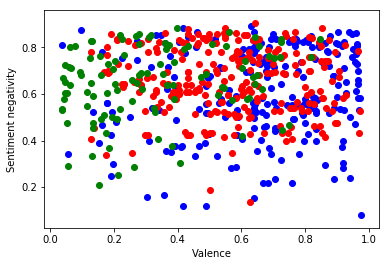

In [26]:
plt.scatter(beatles_df['valence'], beatles_df['neg'], color='blue')
plt.scatter(stones_df['valence'], stones_df['neg'], color='red')
plt.scatter(radiohead_df['valence'], radiohead_df['neg'], color='green')
plt.xlabel('Valence')
plt.ylabel('Sentiment negativity')
plt.show()

Neutrality, I think, is to do with the confidence in the classification.

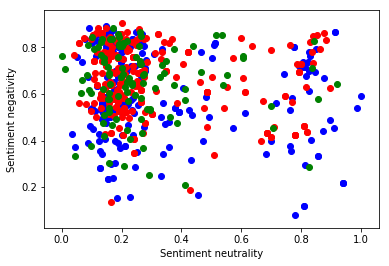

In [27]:
plt.scatter(beatles_df['neutral'], beatles_df['neg'], color='blue')
plt.scatter(stones_df['neutral'], stones_df['neg'], color='red')
plt.scatter(radiohead_df['neutral'], radiohead_df['neg'], color='green')
plt.xlabel('Sentiment neutrality')
plt.ylabel('Sentiment negativity')
plt.show()

This plot shows that most songs have a low neutrality, so express a clear sentiment in the lyrics. Let's plot the distribution of "neutral" scores to highlight this.

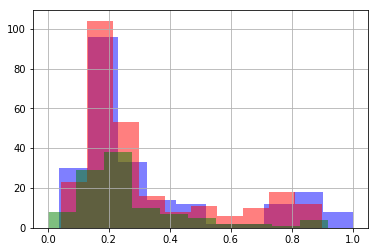

In [28]:
beatles_df['neutral'].hist(alpha=0.5, color='blue')
stones_df['neutral'].hist(alpha=0.5, color='red')
radiohead_df['neutral'].hist(alpha=0.5, color='green')

### Gloom index<a name="gloomindex"></a>
Let's recreate the "gloom index" idea from the original post and see what it tells us. Bear in mind that I'm using the sentiment negativity score, not the fraction of "sad" words.

* [Top](#top)

In [30]:
pipeline = [
    {'$match': {'lyrics': {'$exists': True}, 'sentiment': {'$exists': True}, 'valence': {'$exists': True}}},
    {'$project': {'artist_name': '$artist_name',
                  'name': '$name',
                  'valence': '$valence',
                  'neg': '$sentiment.probability.neg',
                  'lyrical_density': '$lyrical_density',
                  'gloom': {'$divide': [{'$add': [{'$subtract': [1, '$valence']},
                                                  {'$multiply': ['$sentiment.probability.neg', 
                                                                 {'$add': ['$lyrical_density', 1]}]}]}, 
                                        2]}}}]
results = pd.DataFrame(list(tracks.aggregate(pipeline)))
results.sort_values('gloom', ascending=False).head(20)

,_id,artist_name,gloom,lyrical_density,name,neg,valence
584,61IKhUU0ZJ9Ba4GpjlDPju,The Rolling Stones,5.285310,10.523385,Everybody Needs Somebody To Love - Live In Ire...,0.861867,0.3610
360,7DgRvvPcJlxks2lNpudsuT,The Rolling Stones,1.989127,2.886214,Petrol Blues,0.877526,0.4320
282,66cuLvkHsW7dNkfNk6gQP9,Radiohead,1.505262,1.991725,A Wolf At the Door,0.793363,0.3630
354,624njB7Ny3mlA46QokEin9,The Rolling Stones,1.494305,1.966968,No Spare Parts,0.854950,0.5480
526,6KfP8KsoS4I7aSpOvG0ZxE,The Rolling Stones,1.493590,2.348402,Twenty Flight Rock - Live - 2009 Re-Mastered D...,0.780128,0.6250
231,2Iccm3cKBQHWt5yk0yX9nh,The Beatles,1.479822,2.192747,Please Please Me - Remastered 2009,0.835533,0.7080
8,0GRplBEB2FWCKutwMmS6nY,The Beatles,1.475037,1.853118,Ticket To Ride - Live / Remastered,0.825439,0.4050
505,6ncZ7LP1NY4IOp2zQLPOPX,The Rolling Stones,1.415919,1.704903,Fight - Remastered 2009,0.841745,0.4450
466,6j3En9AD8FEAQQhhtkKBR9,The Rolling Stones,1.405004,3.749956,Continental Drift - Live - 2009 Re-Mastered Di...,0.408216,0.1290
255,5SdmtFbNOD7Qej6jFCHkOM,Radiohead,1.398920,1.411166,Faust Arp,0.838532,0.2240


Interestingly, the gloomiest songs seem pretty evenly spread between artists.

In [31]:
pipeline = [
    {'$match': {'lyrics': {'$exists': True}, 'sentiment': {'$exists': True}, 'valence': {'$exists': True},
               'artist_id': radiohead_id}},
    {'$project': {'artist_name': '$artist_name',
                  'name': '$name',
                  'valence': '$valence',
                  'neg': '$sentiment.probability.neg',
                  'lyrical_density': '$lyrical_density',
                  'gloom': {'$divide': [{'$add': [{'$subtract': [1, '$valence']},
                                                  {'$multiply': ['$sentiment.probability.neg', 
                                                                 {'$add': ['$lyrical_density', 1]}]}]}, 
                                        2]}}}]
results = pd.DataFrame(list(tracks.aggregate(pipeline)))
results.sort_values('gloom', ascending=False).head(10)

,_id,artist_name,gloom,lyrical_density,name,neg,valence
51,66cuLvkHsW7dNkfNk6gQP9,Radiohead,1.505262,1.991725,A Wolf At the Door,0.793363,0.3630
24,5SdmtFbNOD7Qej6jFCHkOM,Radiohead,1.398920,1.411166,Faust Arp,0.838532,0.2240
83,3aDUSpF3LexOr1lFKvPV2h,Radiohead,1.239768,1.100731,The Bends,0.854244,0.3150
13,0eZN5WsQfmNFICHuw59Zfz,Radiohead,1.150902,0.705463,Glass Eyes,0.800195,0.0629
98,3ovbSnT5NNhl1gzMcw1NRZ,Radiohead,1.142115,1.151468,Thinking About You,0.791660,0.4190
85,045sp2JToyTaaKyXkGejPy,Radiohead,1.090813,0.581341,Fake Plastic Trees,0.827542,0.1270
84,5jafMI8FLibnjkYTZ33m0c,Radiohead,1.082242,0.858319,High And Dry,0.820356,0.3600
102,4D6ZExVvYLZxhcAvifX5px,Radiohead,1.074047,0.749795,Prove Yourself,0.815006,0.2780
88,4SE81CrzH0qPA8KHqM9Syz,Radiohead,1.064914,0.856048,Just,0.809154,0.3720
74,4aOAzvRdOsZSwZIgwcdeL0,Radiohead,1.063868,0.524102,Let Down,0.825887,0.1310


These, in theory, are the most depressing Radiohead songs. For information, the [fitteR happieR songs](http://rcharlie.com/2017-02-16-fitteR-happieR/) were:

  | gloom_index|               track_name
--|------------|--------------------------|
1 |        1.00 |           True Love Waits
2 |        6.46 |        Give Up The Ghost
3 |        9.35 | Motion Picture Soundtrack
4 |       13.70 |                 Let Down
5 |       14.15 |             Pyramid Song
6 |       14.57 |  Exit Music (For a Film)
7 |       15.29 |          Dollars & Cents
8 |       15.69 |              High And Dry
9 |       15.80 | Tinker Tailor Soldier ...
10|       16.03 |                Videotape

...which has only two songs in common, "High and Dry" and "Let Down". I'm not convinced by this analysis.

What does the same analysis say for The Beatles?

In [32]:
pipeline = [
    {'$match': {'lyrics': {'$exists': True}, 'sentiment': {'$exists': True}, 'valence': {'$exists': True},
               'artist_id': beatles_id}},
    {'$project': {'artist_name': '$artist_name',
                  'name': '$name',
                  'valence': '$valence',
                  'neg': '$sentiment.probability.neg',
                  'lyrical_density': '$lyrical_density',
                  'gloom': {'$divide': [{'$add': [{'$subtract': [1, '$valence']},
                                                  {'$multiply': ['$sentiment.probability.neg', 
                                                                 {'$add': ['$lyrical_density', 1]}]}]}, 
                                        2]}}}]
results = pd.DataFrame(list(tracks.aggregate(pipeline)))
results.sort_values('gloom', ascending=False).head(10)

,_id,artist_name,gloom,lyrical_density,name,neg,valence
219,2Iccm3cKBQHWt5yk0yX9nh,The Beatles,1.479822,2.192747,Please Please Me - Remastered 2009,0.835533,0.7080
4,0GRplBEB2FWCKutwMmS6nY,The Beatles,1.475037,1.853118,Ticket To Ride - Live / Remastered,0.825439,0.4050
87,3VgxeWOGdUYvtX1j8C9VyV,The Beatles,1.393697,1.708599,I'm So Tired - Remastered 2009,0.892489,0.6300
106,6ZrPbHp9kRmQj1tGLvna8U,The Beatles,1.270327,0.874479,Revolution 9 - Remastered 2009,0.873285,0.0963
72,5H9q6ctIlamkqukdTrNt3k,The Beatles,1.261539,2.616693,Her Majesty - Remastered 2009,0.556608,0.4900
23,0mNQUZEATk2uItMUtiLWK5,The Beatles,1.213645,1.615224,A Hard Day's Night - Remastered 2015,0.833309,0.7520
110,0ttMfoND7IQqFSMVOPkELC,The Beatles,1.212148,0.799772,Blue Jay Way - Remastered 2009,0.812490,0.0380
159,5ou2BiQ9FxIYkxsYvYHpAT,The Beatles,1.210378,1.648037,Help! - Remastered 2009,0.823915,0.7610
10,1alcPfZWUHh01l4Fnoo5Jt,The Beatles,1.203416,1.332561,Help! - Live / Remastered,0.823915,0.5150
27,1dfuJYDSIc41cw5RPsaCF1,The Beatles,1.187438,1.651824,Help! - Remastered 2015,0.823915,0.8100


In [33]:
pipeline = [
    {'$match': {'lyrics': {'$exists': True}, 'sentiment': {'$exists': True}, 'valence': {'$exists': True},
               'artist_id': stones_id}},
    {'$project': {'artist_name': '$artist_name',
                  'name': '$name',
                  'valence': '$valence',
                  'neg': '$sentiment.probability.neg',
                  'lyrical_density': '$lyrical_density',
                  'gloom': {'$divide': [{'$add': [{'$subtract': [1, '$valence']},
                                                  {'$multiply': ['$sentiment.probability.neg', 
                                                                 {'$add': ['$lyrical_density', 1]}]}]}, 
                                        2]}}}]
results = pd.DataFrame(list(tracks.aggregate(pipeline)))
results.sort_values('gloom', ascending=False).head(10)

,_id,artist_name,gloom,lyrical_density,name,neg,valence
239,61IKhUU0ZJ9Ba4GpjlDPju,The Rolling Stones,5.285310,10.523385,Everybody Needs Somebody To Love - Live In Ire...,0.861867,0.361
26,7DgRvvPcJlxks2lNpudsuT,The Rolling Stones,1.989127,2.886214,Petrol Blues,0.877526,0.432
20,624njB7Ny3mlA46QokEin9,The Rolling Stones,1.494305,1.966968,No Spare Parts,0.854950,0.548
187,6KfP8KsoS4I7aSpOvG0ZxE,The Rolling Stones,1.493590,2.348402,Twenty Flight Rock - Live - 2009 Re-Mastered D...,0.780128,0.625
166,6ncZ7LP1NY4IOp2zQLPOPX,The Rolling Stones,1.415919,1.704903,Fight - Remastered 2009,0.841745,0.445
127,6j3En9AD8FEAQQhhtkKBR9,The Rolling Stones,1.405004,3.749956,Continental Drift - Live - 2009 Re-Mastered Di...,0.408216,0.129
156,5KOVxb4tOeZsqf4e8zWxb7,The Rolling Stones,1.398919,1.704903,Fight,0.841745,0.479
248,31KuT5lcyp6NlDBjp3EVTp,The Rolling Stones,1.337550,1.571730,The Last Time - Live In Ireland / 1965,0.839551,0.484
67,55XOZpymv9A70smv1fL5zr,The Rolling Stones,1.332593,1.162859,Rocks Off - Live Licks Tour - 2009 Re-Mastered...,0.857748,0.190
35,3jhHx1k3hweq3lunTHp79w,The Rolling Stones,1.283822,1.635406,"She Was Hot - Live At The Beacon Theatre, New ...",0.782287,0.494


### Revised gloom index<a name="revisedgloomindex"></a>
I don't like the calculation for gloom index. If the point of "lyrical density" is to scale the gloom index between valence and sentiment, depending on how many words are in the song. Let's do that weighting properly.

$$gloom = \frac{(1 - normedLyricDensity)\times(1 - valence) + normedLyricDensity \times negativity }{2}$$

* [Top](#top)

In [34]:
pipeline = [
    {'$match': {'lyrics': {'$exists': True}, 'sentiment': {'$exists': True}, 'valence': {'$exists': True}}},
    {'$project': {'artist_name': '$artist_name',
                  'name': '$name',
                  'valence': '$valence',
                  'neg': '$sentiment.probability.neg',
                  'lyrical_density': '$lyrical_density'}}]
results = pd.DataFrame(list(tracks.aggregate(pipeline)))

# Use pandas to scale the lyrical density values to the range 0 -1
results['scaled_ld'] = (results['lyrical_density'] - results['lyrical_density'].min()) / \
    (results['lyrical_density'].max() - results['lyrical_density'].min())

# Define a Python function to calculate the revised gloom index
def gloom(row):
    w_valence = (1 - row['valence']) * (1 - row['scaled_ld'])
    w_neg = row['neg'] * row['scaled_ld']
    return (w_valence + w_neg) / 2

# Apply this function to create a new column
results['gloom'] = results.apply(gloom, axis=1)

# Push the results back into the database
for row in results.itertuples():
    tracks.update_one({'_id': row[1]}, {'$set': {'gloom': row.gloom}})

results.sort_values('gloom', ascending=False).head(10)

,_id,artist_name,lyrical_density,name,neg,valence,scaled_ld,gloom
249,01ZpFhrMMqKPVCwyqXneVp,Radiohead,0.218723,True Love Waits,0.532206,0.0378,0.012017,0.478516
312,75YUnz58ajMo2VIIuUFvOV,Radiohead,0.248061,The Tourist,0.667864,0.0400,0.014830,0.477834
275,53RYTfkLiyZuUZHwJC3Wmm,Radiohead,0.276367,We Suck Young Blood,0.535358,0.0378,0.017543,0.477356
261,4gq2bc2770XvbJdEtfUbmw,Radiohead,0.201546,Go Slowly,0.723774,0.0453,0.010370,0.476153
115,0ttMfoND7IQqFSMVOPkELC,The Beatles,0.799772,Blue Jay Way - Remastered 2009,0.812490,0.0380,0.067726,0.475937
271,5olWalQH1oVza5D6xJg4oX,Radiohead,0.216752,Sail To The Moon,0.605798,0.0458,0.011828,0.475040
300,0COiZ7ncho2yi4HotbzgPv,Radiohead,0.349157,Motion Picture Soundtrack,0.576808,0.0425,0.024522,0.474082
259,3uxhyRdWVXp7GQvERQl6fA,Radiohead,0.382643,Videotape,0.652962,0.0468,0.027733,0.472437
248,3cual6JOG286qZJmCxKRAT,Radiohead,0.332577,Tinker Tailor Soldier Sailor Rich Man Poor Man...,0.477322,0.0517,0.022933,0.468750
208,4sLGaMl33I6mcsk7u4xHAU,Radiohead,0.146307,Codex,0.637942,0.0629,0.005074,0.467791


In [35]:
results[results['artist_name'] == 'Radiohead'].sort_values('gloom', ascending=False).head(10)

,_id,artist_name,lyrical_density,name,neg,valence,scaled_ld,gloom
249,01ZpFhrMMqKPVCwyqXneVp,Radiohead,0.218723,True Love Waits,0.532206,0.0378,0.012017,0.478516
312,75YUnz58ajMo2VIIuUFvOV,Radiohead,0.248061,The Tourist,0.667864,0.0400,0.014830,0.477834
275,53RYTfkLiyZuUZHwJC3Wmm,Radiohead,0.276367,We Suck Young Blood,0.535358,0.0378,0.017543,0.477356
261,4gq2bc2770XvbJdEtfUbmw,Radiohead,0.201546,Go Slowly,0.723774,0.0453,0.010370,0.476153
271,5olWalQH1oVza5D6xJg4oX,Radiohead,0.216752,Sail To The Moon,0.605798,0.0458,0.011828,0.475040
300,0COiZ7ncho2yi4HotbzgPv,Radiohead,0.349157,Motion Picture Soundtrack,0.576808,0.0425,0.024522,0.474082
259,3uxhyRdWVXp7GQvERQl6fA,Radiohead,0.382643,Videotape,0.652962,0.0468,0.027733,0.472437
248,3cual6JOG286qZJmCxKRAT,Radiohead,0.332577,Tinker Tailor Soldier Sailor Rich Man Poor Man...,0.477322,0.0517,0.022933,0.468750
208,4sLGaMl33I6mcsk7u4xHAU,Radiohead,0.146307,Codex,0.637942,0.0629,0.005074,0.467791
292,5AiNZnMDCWwujIENPj9PV9,Radiohead,0.489208,Everything In Its Right Place,0.716829,0.0585,0.037950,0.466487


This still isn't the same as the original list, though there are now three songs in common ("True Love Waits", "Motion Picture Soundtrack", and "Tinker Tailor…") and the lists agree on the gloomiest song!

  | gloom_index |               track_name
--|-------------|--------------------------
1 |        1.00 |           True Love Waits
2 |        6.46 |        Give Up The Ghost
3 |        9.35 | Motion Picture Soundtrack
4 |       13.70 |                 Let Down
5 |       14.15 |             Pyramid Song
6 |       14.57 |  Exit Music (For a Film)
7 |       15.29 |          Dollars & Cents
8 |       15.69 |              High And Dry
9 |       15.80 | Tinker Tailor Soldier ...
10|       16.03 |                Videotape


In [37]:
results[results['artist_name'] == 'The Rolling Stones'].sort_values('gloom', ascending=False).head(10)

,_id,artist_name,lyrical_density,name,neg,valence,scaled_ld,gloom
457,1dTX9ivyAhFJLR1f2pk9Kv,The Rolling Stones,0.360195,Out Of Tears - 2009 Re-Mastered Digital Version,0.782248,0.128,0.025581,0.434852
584,61IKhUU0ZJ9Ba4GpjlDPju,The Rolling Stones,10.523385,Everybody Needs Somebody To Love - Live In Ire...,0.861867,0.361,1.000000,0.430933
604,388ll2SEjDO9LZIXXyKtjh,The Rolling Stones,0.301584,Little Rain,0.455221,0.137,0.019961,0.427430
437,1qEGxs60ntxuenj27BnRkF,The Rolling Stones,0.551257,How Can I Stop - 2009 Digital Remaster,0.695197,0.169,0.043899,0.412519
428,7tWJEqPI5Jpie3NhtbWks6,The Rolling Stones,0.570166,Already Over Me - 2009 Digital Remaster,0.803540,0.179,0.045712,0.410101
566,7G6Z0sDe39MFjTaA0XfCtw,The Rolling Stones,0.444033,I Can't Quit You Baby,0.766732,0.179,0.033619,0.409588
404,55XOZpymv9A70smv1fL5zr,The Rolling Stones,1.162859,Rocks Off - Live Licks Tour - 2009 Re-Mastered...,0.857748,0.190,0.102538,0.407448
464,6wo8Eid3jXbaScSEpv0IQO,The Rolling Stones,0.357249,Thru and Thru - 2009 Re-Mastered Digital Version,0.692118,0.182,0.025298,0.407408
415,79etUS7LGTYLlfhGt77ZAK,The Rolling Stones,0.581741,Street Fighting Man - Live Licks Tour - 2009 R...,0.695022,0.185,0.046822,0.404691
409,07U5DnoRtB0DSlonXx2jym,The Rolling Stones,0.867761,When The Whip Comes Down - Live Licks Tour - 2...,0.698597,0.182,0.074245,0.404567


In [36]:
results[results['artist_name'] == 'The Beatles'].sort_values('gloom', ascending=False).head(10)

,_id,artist_name,lyrical_density,name,neg,valence,scaled_ld,gloom
115,0ttMfoND7IQqFSMVOPkELC,The Beatles,0.799772,Blue Jay Way - Remastered 2009,0.812490,0.0380,0.067726,0.475937
149,0agoaPIy92gPZ6zRhqXarE,The Beatles,0.634931,Tomorrow Never Knows - Remastered 2009,0.343599,0.0556,0.051922,0.456603
111,6ZrPbHp9kRmQj1tGLvna8U,The Beatles,0.874479,Revolution 9 - Remastered 2009,0.873285,0.0963,0.074889,0.450711
106,27YZJHyTTDIurMqDu1v2ef,The Beatles,0.429399,"Long, Long, Long - Remastered 2009",0.524122,0.1350,0.032216,0.427009
3,2ucFulEWapRAmTn7l6f5Q7,The Beatles,0.169898,Wild Honey Pie - Remastered 2009,0.391178,0.1530,0.007336,0.421828
135,3ZFBeIyP41HhnALjxWy1pR,The Beatles,0.628310,A Day In The Life - Remastered 2009,0.781296,0.1620,0.051287,0.417546
68,4cLoL5KPfE1hAwfsO84FX7,The Beatles,0.325955,Because - Remastered 2009,0.466254,0.1620,0.022298,0.414855
46,7iABnSNZciNepqGtjMQxxd,The Beatles,0.800176,Come Together - Remastered 2015,0.562552,0.1780,0.067765,0.402209
61,0MKqeOVdZcUFGJvWpGCKbG,The Beatles,0.796316,Come Together - Remastered 2009,0.562552,0.1790,0.067395,0.401791
70,3jPXnX4SskFgAcC4YBKOwN,The Beatles,0.273472,Sun King - Remastered 2009,0.300809,0.1970,0.017266,0.397165


I don't know the Radiohead corpus, but I know some Beatles songs. _Blue Jay Way_ is pretty sad, as is _A Day in the Life_. _Revolution 9_ and _Wild Honey Pie_ are just... odd, rather than sad. It's suspicious that some obviously sad Beatles songs are missing. What does this analysis think of unequivocally sad songs like _She's Leaving Home_, _Yesterday_, and _Eleanor Rigby_?

In [38]:
slh = tracks.find_one({'ctitle': 'shes leaving home'})['_id']
yd = tracks.find_one({'ctitle': 'yesterday'})['_id']
er = tracks.find_one({'ctitle': 'eleanor rigby'})['_id']
results[results['_id'].isin([slh, yd, er])].sort_values('gloom', ascending=False)

,_id,artist_name,lyrical_density,name,neg,valence,scaled_ld,gloom
32,63uskN0xLezVg4281wzeQn,The Beatles,1.005426,Yesterday - Remastered 2015,0.852156,0.348,0.087444,0.334751
128,1Ipl1kvks5s6GKn6oqgzeY,The Beatles,1.064324,She's Leaving Home - Remastered 2009,0.764553,0.377,0.093091,0.318089
37,0TRkjwb4uY3CHb5zhr9bBd,The Beatles,1.628703,Eleanor Rigby - Remastered 2015,0.803232,0.845,0.147202,0.125210


### Glee index: anti-gloom<a name="gleeindex"></a>
Rather than looking at the saddest songs, how about using the same data to find the happiest songs?

* [Top](#top)

In [39]:
results.sort_values('gloom', ascending=True).head(10)

,_id,artist_name,lyrical_density,name,neg,valence,scaled_ld,gloom
87,3fuEJBCK3kWnJHFTODR4cb,The Beatles,1.608806,"Ob-La-Di, Ob-La-Da - Remastered 2009",0.080969,0.975,0.145294,0.016566
518,4FHhq0QWpLSS6WZnkJnZp1,The Rolling Stones,0.312839,Feel On Baby - 2009 Re-Mastered Digital Version,0.784292,0.965,0.021040,0.025383
440,4g9KfIW09EJnXXRY8vR69q,The Rolling Stones,0.713929,Not Fade Away - Live - 2009 Re-Mastered Digita...,0.433042,0.969,0.059496,0.027460
223,5VsIn7QQqcacePIb0vO0ow,The Beatles,0.465201,Not A Second Time - Remastered 2009,0.773805,0.961,0.035648,0.032597
219,6xJSJpO6HJwHhu7UaIc8qR,The Beatles,0.585885,Hold Me Tight - Remastered 2009,0.804870,0.963,0.047219,0.036629
81,3TEbDhNDU4NDXq0h86nGZ7,The Beatles,1.008850,Hey Bulldog - Remastered 2009,0.239198,0.942,0.087772,0.036952
59,0cJ053ljI4BuP5P8tJnK5j,The Beatles,0.893485,For You Blue - Remastered 2009,0.471827,0.958,0.076711,0.037486
144,6RdvhWyzCULNTHcMbAXwXK,The Beatles,0.879719,And Your Bird Can Sing - Remastered 2009,0.582875,0.966,0.075391,0.037690
23,2Q2Gu7Bv8iLenuygtBgDUw,The Beatles,1.058884,From Me To You - Mono / Remastered 2015,0.529415,0.968,0.092569,0.039023
533,6ml6iL8HUdQKgtMaehAZc8,The Rolling Stones,1.215580,Start Me Up - 2009 Re-Mastered Digital Version,0.524795,0.971,0.107593,0.041172


All the top ten most gleeful songs are from The Beatles!

What about the most gleeful Radiohead songs?

In [40]:
results[results['artist_name'] == 'Radiohead'].sort_values('gloom', ascending=True).head(10)

,_id,artist_name,lyrical_density,name,neg,valence,scaled_ld,gloom
250,6dsq7Nt5mIFzvm5kIYNORy,Radiohead,0.674272,15 Step,0.835488,0.848,0.055694,0.095033
258,15ea10YpJIl3mJq75yzqsD,Radiohead,0.952216,Jigsaw Falling Into Place,0.757225,0.818,0.082342,0.114683
4,0eECFDnWy0RdjMmJ8NOeAL,Radiohead,0.093389,Feral,0.465216,0.751,0.000000,0.124500
277,77SPrxY5gn6VPrKPGrfLnM,Radiohead,0.438813,"There, There",0.835541,0.726,0.033118,0.146299
272,6CVdTDYoDbwYj4xn8u5Gha,Radiohead,0.452573,Backdrifts,0.821532,0.724,0.034438,0.147393
307,53aFGAl0Vebwp2bo8wtdWR,Radiohead,2.019892,Fitter Happier,0.446841,0.728,0.184708,0.152147
266,6P67UTTr5qN7XYSSlj0n6X,Radiohead,0.503609,Paperbag Writer,0.754680,0.704,0.039331,0.157020
251,4m0Vgr48VFaMYw0Sp1ozJu,Radiohead,0.870846,Bodysnatchers,0.759247,0.721,0.074541,0.157399
267,3STByesnbcQatiGHgwi1Tv,Radiohead,0.622541,I Am a Wicked Child,0.763706,0.688,0.050734,0.167458
210,2rA36OZNb3LkvqcNro1ugK,Radiohead,0.836338,Separator,0.622837,0.666,0.071232,0.177287


### Contrasting songs<a name="valencenegcontrast"></a>
Going back to the scatter plot of negativity against valence, there are some songs with a high valence (i.e. sound happy) with a high negativity (i.e. sad words). This seems unusual. What songs are they?

* [Top](#top)

These are the songs I mean:

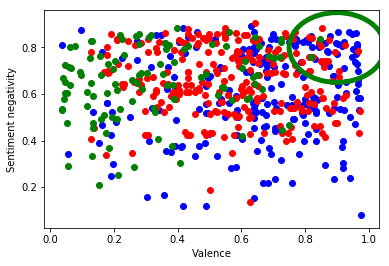

In [42]:
plt.scatter(beatles_df['valence'], beatles_df['neg'], color='blue')
plt.scatter(stones_df['valence'], stones_df['neg'], color='red')
plt.scatter(radiohead_df['valence'], radiohead_df['neg'], color='green')
plt.xlabel('Valence')
plt.ylabel('Sentiment negativity')

ax = plt.gca()
circ = plt.Circle((0.9, 0.8), radius=0.15, color='g', fill=False, linewidth=5)
ax.add_patch(circ)

plt.show()

In [43]:
results[(results['valence'] > 0.8) & (results['neg'] > 0.7)]

,_id,artist_name,lyrical_density,name,neg,valence,scaled_ld,gloom
26,7pQAq14Z73YUFMtxCyt0bG,The Beatles,1.516618,Can't Buy Me Love - Remastered 2015,0.738387,0.957,0.136455,0.068945
31,1dfuJYDSIc41cw5RPsaCF1,The Beatles,1.651824,Help! - Remastered 2015,0.823915,0.810,0.149419,0.142359
37,0TRkjwb4uY3CHb5zhr9bBd,The Beatles,1.628703,Eleanor Rigby - Remastered 2015,0.803232,0.845,0.147202,0.125210
49,57n1teNb2tkcfiYagPmUWr,The Beatles,0.885556,Two Of Us - Remastered 2009,0.711080,0.923,0.075951,0.062579
57,4311wT21Et0q3vepFwXjTu,The Beatles,0.718556,One After 909 - Remastered 2009,0.865737,0.904,0.059939,0.071069
71,67jL5ZAf8hNsRZrfBHNuBT,The Beatles,1.277562,Mean Mr Mustard - Remastered 2009,0.700631,0.967,0.113535,0.054400
96,3OSi8ehmSWLTD5KatlzX8r,The Beatles,0.733338,Don't Pass Me By - Remastered 2009,0.857831,0.948,0.061357,0.050722
97,4zExFATo8xg8qFfR4H1ZAn,The Beatles,1.364176,Why Don't We Do It In The Road? - Remastered 2009,0.793242,0.951,0.121840,0.069839
137,77f3aNeabAbOaSB32Sd5QE,The Beatles,1.620131,Eleanor Rigby - Remastered 2009,0.803232,0.821,0.146380,0.135188
171,67tvBtAhsfHBFpuqJ13ZUq,The Beatles,0.931018,Act Naturally - Remastered 2009,0.756947,0.946,0.080310,0.055227


That's interesting. This list contains a lot of the Beatles' most well-known songs. Is there something in this?

Let's define "complexity" as the product of valence and negativity, and see which are the most complext songs.

In [44]:
results['complexity'] = results['valence'] * results['neg']
results.sort_values('complexity', ascending=False).head(10)

,_id,artist_name,lyrical_density,name,neg,valence,scaled_ld,gloom,complexity
199,3Aqo28W4LLAolYpN3duVJl,The Beatles,1.349222,I'll Cry Instead - Remastered 2009,0.863772,0.961,0.120406,0.069154,0.830085
96,3OSi8ehmSWLTD5KatlzX8r,The Beatles,0.733338,Don't Pass Me By - Remastered 2009,0.857831,0.948,0.061357,0.050722,0.813223
190,3EbGioQyKyf4dycuiPOg3k,The Beatles,0.438356,Everybody's Trying To Be My Baby - Remastered ...,0.866985,0.937,0.033075,0.044796,0.812365
217,5IIBY9M2GxHcVja6DA6wsF,The Beatles,1.362221,Please Mister Postman - Remastered 2009,0.815201,0.962,0.121652,0.066274,0.784223
57,4311wT21Et0q3vepFwXjTu,The Beatles,0.718556,One After 909 - Remastered 2009,0.865737,0.904,0.059939,0.071069,0.782626
219,6xJSJpO6HJwHhu7UaIc8qR,The Beatles,0.585885,Hold Me Tight - Remastered 2009,0.804870,0.963,0.047219,0.036629,0.775090
214,0lLeGCsQlAbEjQBPQQxQ1b,The Beatles,0.998293,Don't Bother Me - Remastered 2009,0.824879,0.921,0.086760,0.071856,0.759713
518,4FHhq0QWpLSS6WZnkJnZp1,The Rolling Stones,0.312839,Feel On Baby - 2009 Re-Mastered Digital Version,0.784292,0.965,0.021040,0.025383,0.756841
97,4zExFATo8xg8qFfR4H1ZAn,The Beatles,1.364176,Why Don't We Do It In The Road? - Remastered 2009,0.793242,0.951,0.121840,0.069839,0.754373
392,4sLirGgpkyL3RSdr13q3wd,The Rolling Stones,1.329366,She Saw Me Coming - 2009 Re-Mastered Digital V...,0.885088,0.852,0.118502,0.117673,0.754095


There's possibly something in it. The most "complex" song has a very upbeat pop tune and very sad lyrics. The others are similarly interesting.

What about the least "complex" songs?

In [45]:
results.sort_values('complexity', ascending=True).head(10)

,_id,artist_name,lyrical_density,name,neg,valence,scaled_ld,gloom,complexity
246,6f6pEjgfTtuRROmJ4a7Gf3,Radiohead,0.393192,The Numbers,0.292008,0.0545,0.028744,0.463358,0.015914
149,0agoaPIy92gPZ6zRhqXarE,The Beatles,0.634931,Tomorrow Never Knows - Remastered 2009,0.343599,0.0556,0.051922,0.456603,0.019104
249,01ZpFhrMMqKPVCwyqXneVp,Radiohead,0.218723,True Love Waits,0.532206,0.0378,0.012017,0.478516,0.020117
275,53RYTfkLiyZuUZHwJC3Wmm,Radiohead,0.276367,We Suck Young Blood,0.535358,0.0378,0.017543,0.477356,0.020237
300,0COiZ7ncho2yi4HotbzgPv,Radiohead,0.349157,Motion Picture Soundtrack,0.576808,0.0425,0.024522,0.474082,0.024514
248,3cual6JOG286qZJmCxKRAT,Radiohead,0.332577,Tinker Tailor Soldier Sailor Rich Man Poor Man...,0.477322,0.0517,0.022933,0.468750,0.024678
312,75YUnz58ajMo2VIIuUFvOV,Radiohead,0.248061,The Tourist,0.667864,0.0400,0.014830,0.477834,0.026715
271,5olWalQH1oVza5D6xJg4oX,Radiohead,0.216752,Sail To The Moon,0.605798,0.0458,0.011828,0.475040,0.027746
259,3uxhyRdWVXp7GQvERQl6fA,Radiohead,0.382643,Videotape,0.652962,0.0468,0.027733,0.472437,0.030559
115,0ttMfoND7IQqFSMVOPkELC,The Beatles,0.799772,Blue Jay Way - Remastered 2009,0.812490,0.0380,0.067726,0.475937,0.030875


Interestingly, all of the "complex" songs are by The Beatles, while most of the least "complex" songs are by Radiohead. How true is that for all songs?

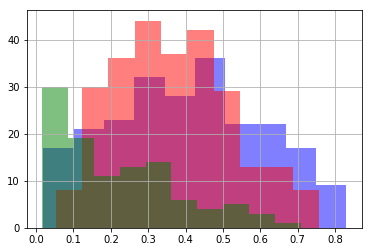

In [46]:
results[results['artist_name'] == 'The Beatles']['complexity'].hist(alpha=0.5, color='blue')
results[results['artist_name'] == 'The Rolling Stones']['complexity'].hist(alpha=0.5, color='red')
results[results['artist_name'] == 'Radiohead']['complexity'].hist(alpha=0.5, color='green')

In [47]:
# Push the results back into the database
for row in results.itertuples():
    tracks.update_one({'_id': row[1]}, {'$set': {'complexity': row.complexity}})

### Average gloom per album<a name="gloomperalbum"></a>
How close can we easily get to the final plot at the end of the fitteR happieR post?

First, we find average gloom per album.

* [Top](#top)

In [48]:
pipeline = [
    {'$match': {'gloom': {'$exists': True}}},
    {'$group': {'_id': '$album.id', 'avg_gloom': {'$avg': '$gloom'}}}]
album_glooms = collections.defaultdict(int, {a['_id']: a['avg_gloom'] for a in tracks.aggregate(pipeline)})
album_glooms

defaultdict(int,
            {'03Qh833fEdVT30Pfs93ea6': 0.22789678983941528,
             '064eFGemsrDcMvgRZ0gqtw': 0.16546281355794068,
             '0PYyrqs9NXtxPhf0CZkq2L': 0.2004709034333945,
             '0ZGddnvcVzHVHfE3WW1tV5': 0.2525963821085444,
             '0hxrNynMDh5QeyALlf1CdS': 0.20593474908558748,
             '19K3IHYeVkUTjcBHGfbCOi': 0.15931668274756888,
             '19RUXBFyM4PpmrLRdtqWbp': 0.3425419294911015,
             '1DBkJIEoeHrTX4WCBQGcCi': 0.27771871919334173,
             '1PULmKbHeOqlkIwcDMNwD4': 0.1990729877861721,
             '1TpcI1LEFVhBvDPSTMPGFG': 0.22099628190640677,
             '1W1UJulgICjFDyYIMUwRs7': 0.24617308215264266,
             '1WSfNoPDPzgyKFN6OSYWUx': 0.2200357402700505,
             '1YvnuYGlblQ5vLnOhaZzpn': 0.16615180659586304,
             '1oW3v5Har9mvXnGk0x4fHm': 0.30508738391274,
             '25mfHGJNQkluvIqedXHSx3': 0.1483635997905052,
             '2Pqkn9Dq2DFtdfkKAeqgMd': 0.27685980377092695,
             '2pCqZLeavM2BMovJXs

In [49]:
albums_df = pd.DataFrame(list(albums.find({}, ['release_date', 'name', 'artist_name'])))

def try_date(d):
    try:
        return datetime.strptime(d, "%Y-%m-%d")
    except ValueError:
        return datetime.strptime(d, "%Y")

albums_df['release_date'] = albums_df['release_date'].apply(lambda d: try_date(d))
albums_df['gloom'] = albums_df['_id'].apply(lambda i: album_glooms[i])
albums_df.sort_values('release_date', inplace=True)
albums_df

,_id,artist_name,name,release_date,gloom
15,7gDXyW16byCQOgK965BRzn,The Beatles,Please Please Me (Remastered),1963-03-22,0.124247
14,3nkEsxmIX0zRNXGAexaHAn,The Beatles,With The Beatles (Remastered),1963-11-22,0.087488
12,71Mwd9tntFQYUk4k2DwA0D,The Beatles,A Hard Day's Night (Remastered),1964-07-10,0.144607
11,7BgGBZndAvDlKOcwe5rscZ,The Beatles,Beatles For Sale (Remastered),1964-12-04,0.118608
10,19K3IHYeVkUTjcBHGfbCOi,The Beatles,Help! (Remastered),1965-08-06,0.159317
9,3OdI6e43crvyAHhaqpxSyz,The Beatles,Rubber Soul (Remastered),1965-12-03,0.161066
8,0PYyrqs9NXtxPhf0CZkq2L,The Beatles,Revolver (Remastered),1966-08-05,0.200471
7,1PULmKbHeOqlkIwcDMNwD4,The Beatles,Sgt. Pepper's Lonely Hearts Club Band (Remaste...,1967-06-01,0.199073
6,6P9yO0ukhOx3dvmhGKeYoC,The Beatles,Magical Mystery Tour (Remastered),1967-11-27,0.259741
5,03Qh833fEdVT30Pfs93ea6,The Beatles,The Beatles (Remastered),1968-11-22,0.227897


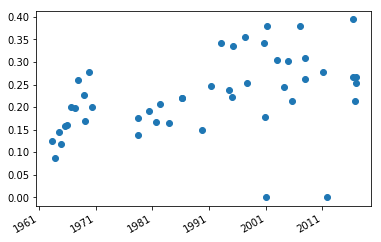

In [50]:
fig, ax = plt.subplots()
ax.plot_date(albums_df['release_date'], albums_df['gloom'])

fig.autofmt_xdate()
plt.show()

One thing that's noticable is the split in time between the groups, and the much shorter period the Beatles were active for.

In [67]:
beatles_df = albums_df[  (albums_df['artist_name'] == 'The Beatles') 
                       & (albums_df['gloom'] > 0) 
                       & (albums_df['release_date'] < datetime(1971, 1, 1))]
beatles_df

,_id,artist_name,name,release_date,gloom,complexity
15,7gDXyW16byCQOgK965BRzn,The Beatles,Please Please Me (Remastered),1963-03-22,0.124247,0.473380
14,3nkEsxmIX0zRNXGAexaHAn,The Beatles,With The Beatles (Remastered),1963-11-22,0.087488,0.578515
12,71Mwd9tntFQYUk4k2DwA0D,The Beatles,A Hard Day's Night (Remastered),1964-07-10,0.144607,0.549059
11,7BgGBZndAvDlKOcwe5rscZ,The Beatles,Beatles For Sale (Remastered),1964-12-04,0.118608,0.508739
10,19K3IHYeVkUTjcBHGfbCOi,The Beatles,Help! (Remastered),1965-08-06,0.159317,0.494990
9,3OdI6e43crvyAHhaqpxSyz,The Beatles,Rubber Soul (Remastered),1965-12-03,0.161066,0.449000
8,0PYyrqs9NXtxPhf0CZkq2L,The Beatles,Revolver (Remastered),1966-08-05,0.200471,0.395546
7,1PULmKbHeOqlkIwcDMNwD4,The Beatles,Sgt. Pepper's Lonely Hearts Club Band (Remaste...,1967-06-01,0.199073,0.331375
6,6P9yO0ukhOx3dvmhGKeYoC,The Beatles,Magical Mystery Tour (Remastered),1967-11-27,0.259741,0.275272
5,03Qh833fEdVT30Pfs93ea6,The Beatles,The Beatles (Remastered),1968-11-22,0.227897,0.303138


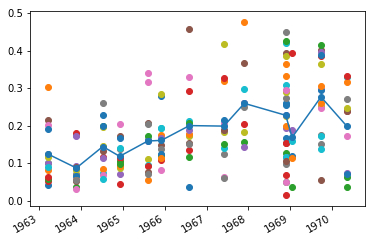

In [68]:
fig, ax = plt.subplots()
ax.plot_date(beatles_df['release_date'].values, beatles_df['gloom'].values, linestyle='-')

fig.autofmt_xdate()

for a in beatles_df.itertuples():
    for t in tracks.find({'album.id': a[1], 'gloom': {'$exists': True}}):
        ax.scatter(a.release_date, t['gloom'])

plt.show()

In [69]:
stones_df = albums_df[(albums_df['artist_name'] == 'The Rolling Stones') & (albums_df['gloom'] > 0)]
stones_df

,_id,artist_name,name,release_date,gloom,complexity
46,54sqbAXxR1jFfyXb1WvrHK,The Rolling Stones,Some Girls,1978-06-09,0.138254,0.478235
47,6FjXxl9VLURGuubdXUn2J3,The Rolling Stones,Some Girls (Deluxe Version),1978-06-09,0.175582,0.460035
45,2wZgoXS06wSdu9C0ZJOvlc,The Rolling Stones,Emotional Rescue (2009 Re-Mastered),1980-06-20,0.191257,0.453852
44,1YvnuYGlblQ5vLnOhaZzpn,The Rolling Stones,Tattoo You (2009 Re-Mastered),1981-08-24,0.166152,0.447257
43,0hxrNynMDh5QeyALlf1CdS,The Rolling Stones,Still Life,1982-06-01,0.205935,0.338044
42,064eFGemsrDcMvgRZ0gqtw,The Rolling Stones,Undercover (2009 Re-Mastered),1983-11-07,0.165463,0.492789
41,1WSfNoPDPzgyKFN6OSYWUx,The Rolling Stones,Dirty Work (Remastered 2009),1986-03-24,0.220036,0.403297
40,1TpcI1LEFVhBvDPSTMPGFG,The Rolling Stones,Dirty Work,1986-03-24,0.220996,0.403350
39,25mfHGJNQkluvIqedXHSx3,The Rolling Stones,Steel Wheels (2009 Re-Mastered),1989-08-29,0.148364,0.456991
38,1W1UJulgICjFDyYIMUwRs7,The Rolling Stones,Flashpoint,1991-04-02,0.246173,0.325013


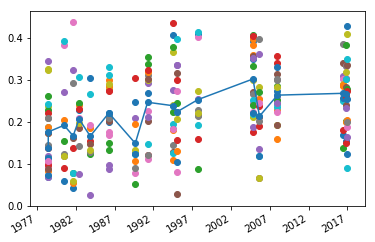

In [70]:
fig, ax = plt.subplots()
ax.plot_date(stones_df['release_date'].values, stones_df['gloom'].values, linestyle='-')

for a in stones_df.itertuples():
    for t in tracks.find({'album.id': a[1], 'gloom': {'$exists': True}}):
        ax.scatter(a.release_date, t['gloom'])

fig.autofmt_xdate()
plt.show()

In [71]:
radiohead_df = albums_df[(albums_df['artist_name'] == 'Radiohead') & (albums_df['gloom'] > 0)]
radiohead_df

,_id,artist_name,name,release_date,gloom,complexity
27,6400dnyeDyD2mIFHfkwHXN,Radiohead,Pablo Honey,1993-02-22,0.343022,0.225363
26,500FEaUzn8lN9zWFyZG5C2,Radiohead,The Bends,1995-03-28,0.335254,0.237786
25,7dxKtc08dYeRVHt3p9CZJn,Radiohead,OK Computer,1997-05-28,0.355863,0.161464
24,19RUXBFyM4PpmrLRdtqWbp,Radiohead,Kid A,2000-10-01,0.342542,0.196824
23,6V9YnBmFjWmXCBaUVRCVXP,Radiohead,Amnesiac,2001-03-12,0.379351,0.156189
21,1oW3v5Har9mvXnGk0x4fHm,Radiohead,Hail To the Thief,2003-01-01,0.305087,0.298984
20,6Eo5EkmdLvZrONzi046iC2,Radiohead,Com Lag: 2+2=5,2004-03-24,0.243590,0.377657
19,36lJLPoPPOKNFddTAcirnc,Radiohead,In Rainbows Disk 2,2007-01-01,0.379263,0.170416
18,7eyQXxuf2nGj9d2367Gi5f,Radiohead,In Rainbows,2007-12-28,0.308895,0.291347
13,1DBkJIEoeHrTX4WCBQGcCi,Radiohead,The King Of Limbs,2011-02-18,0.277719,0.238094


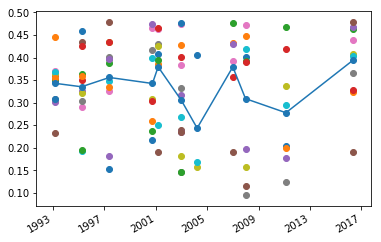

In [72]:
fig, ax = plt.subplots()
ax.plot_date(radiohead_df['release_date'].values, radiohead_df['gloom'].values, linestyle='-')

for a in radiohead_df.itertuples():
    for t in tracks.find({'album.id': a[1], 'gloom': {'$exists': True}}):
        ax.scatter(a.release_date, t['gloom'])

fig.autofmt_xdate()
plt.show()

## Complexity per album<a name="complexityovertime"></a>
Let's generate the same plots for "complexity" per album.

* [Top](#top)

In [60]:
pipeline = [
    {'$match': {'gloom': {'$exists': True}}},
    {'$group': {'_id': '$album.id', 'avg_complexity': {'$avg': '$complexity'}}}]
album_complexities = collections.defaultdict(int, {a['_id']: a['avg_complexity'] for a in tracks.aggregate(pipeline)})
album_complexities

defaultdict(int,
            {'03Qh833fEdVT30Pfs93ea6': 0.3031378075765009,
             '064eFGemsrDcMvgRZ0gqtw': 0.4927887195864442,
             '0PYyrqs9NXtxPhf0CZkq2L': 0.3955461017790891,
             '0ZGddnvcVzHVHfE3WW1tV5': 0.34656364986794674,
             '0hxrNynMDh5QeyALlf1CdS': 0.33804423586511734,
             '19K3IHYeVkUTjcBHGfbCOi': 0.49499034315437085,
             '19RUXBFyM4PpmrLRdtqWbp': 0.19682403824100217,
             '1DBkJIEoeHrTX4WCBQGcCi': 0.23809377712764113,
             '1PULmKbHeOqlkIwcDMNwD4': 0.33137519763673373,
             '1TpcI1LEFVhBvDPSTMPGFG': 0.4033497517243232,
             '1W1UJulgICjFDyYIMUwRs7': 0.32501333748703876,
             '1WSfNoPDPzgyKFN6OSYWUx': 0.40329664833674617,
             '1YvnuYGlblQ5vLnOhaZzpn': 0.4472573341595843,
             '1oW3v5Har9mvXnGk0x4fHm': 0.2989840032500176,
             '25mfHGJNQkluvIqedXHSx3': 0.4569913175605233,
             '2Pqkn9Dq2DFtdfkKAeqgMd': 0.2801541309531463,
             '2pCqZLeavM2BMovJX

In [76]:
albums_df['complexity'] = albums_df['_id'].apply(lambda i: album_complexities[i])
# beatles_df = albums_df[albums_df['release_date'] < datetime(1971, 1, 1)]
beatles_df = albums_df[(albums_df['artist_name'] == 'The Beatles') 
                       & (albums_df['gloom'] > 0)
                       & (albums_df['release_date'] < datetime(1971, 1, 1))]
stones_df = albums_df[(albums_df['artist_name'] == 'The Rolling Stones') & (albums_df['gloom'] > 0)]
radiohead_df = albums_df[(albums_df['artist_name'] == 'Radiohead') & (albums_df['gloom'] > 0)]
albums_df.head()

,_id,artist_name,name,release_date,gloom,complexity
15,7gDXyW16byCQOgK965BRzn,The Beatles,Please Please Me (Remastered),1963-03-22,0.124247,0.473380
14,3nkEsxmIX0zRNXGAexaHAn,The Beatles,With The Beatles (Remastered),1963-11-22,0.087488,0.578515
12,71Mwd9tntFQYUk4k2DwA0D,The Beatles,A Hard Day's Night (Remastered),1964-07-10,0.144607,0.549059
11,7BgGBZndAvDlKOcwe5rscZ,The Beatles,Beatles For Sale (Remastered),1964-12-04,0.118608,0.508739
10,19K3IHYeVkUTjcBHGfbCOi,The Beatles,Help! (Remastered),1965-08-06,0.159317,0.494990


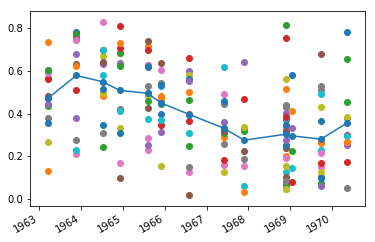

In [77]:
fig, ax = plt.subplots()
ax.plot_date(beatles_df['release_date'].values, beatles_df['complexity'].values, linestyle='-')

fig.autofmt_xdate()

for a in beatles_df.itertuples():
    for t in tracks.find({'album.id': a[1], 'complexity': {'$exists': True}}):
        ax.scatter(a.release_date, t['complexity'])

plt.show()

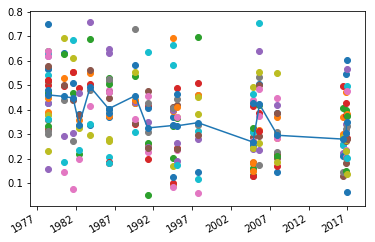

In [78]:
fig, ax = plt.subplots()
ax.plot_date(stones_df['release_date'].values, stones_df['complexity'].values, linestyle='-')

fig.autofmt_xdate()

for a in stones_df.itertuples():
    for t in tracks.find({'album.id': a[1], 'complexity': {'$exists': True}}):
        ax.scatter(a.release_date, t['complexity'])

plt.show()

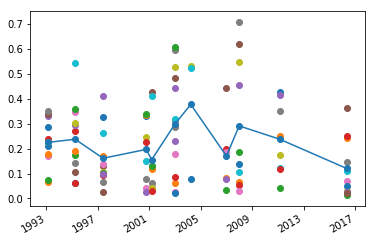

In [79]:
fig, ax = plt.subplots()
ax.plot_date(radiohead_df['release_date'].values, radiohead_df['complexity'].values, linestyle='-')

fig.autofmt_xdate()

for a in radiohead_df.itertuples():
    for t in tracks.find({'album.id': a[1], 'complexity': {'$exists': True}}):
        ax.scatter(a.release_date, t['complexity'])

plt.show()

That isn't what I was expecting. I was expecting the complexity to go up over time, as bands became more adept at contrasting lyrics and melody. It could be because high complexity requires high valence, and bands tend not to become more "poppy" over time.

Let's test that, by also showing the valence of tracks and albums over time.

In [88]:
pipeline = [
    {'$match': {'valence': {'$exists': True}}},
    {'$group': {'_id': '$album.id', 'avg_valence': {'$avg': '$valence'}}}]
album_valences = collections.defaultdict(int, {a['_id']: a['avg_valence'] for a in tracks.aggregate(pipeline)})
albums_df['valence'] = albums_df['_id'].apply(lambda i: album_valences[i])
# beatles_df = albums_df[albums_df['release_date'] < datetime(1971, 1, 1)]
beatles_df = albums_df[(albums_df['artist_name'] == 'The Beatles') 
                       & (albums_df['valence'] > 0)
                       & (albums_df['release_date'] < datetime(1971, 1, 1))]
stones_df = albums_df[(albums_df['artist_name'] == 'The Rolling Stones') 
                         & (albums_df['valence'] > 0)]
radiohead_df = albums_df[(albums_df['artist_name'] == 'Radiohead') 
                         & (albums_df['valence'] > 0)]

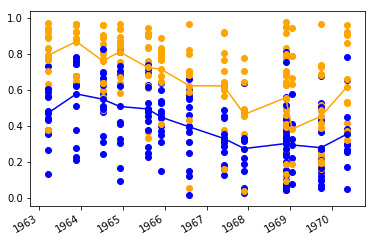

In [85]:
fig, ax = plt.subplots()
ax.plot_date(beatles_df['release_date'].values, beatles_df['complexity'].values, linestyle='-', color='blue')
ax.plot_date(beatles_df['release_date'].values, beatles_df['valence'].values, linestyle='-', color='orange')

fig.autofmt_xdate()

for a in beatles_df.itertuples():
    for t in tracks.find({'album.id': a[1], 'complexity': {'$exists': True}}):
        ax.scatter(a.release_date, t['complexity'], color='blue')
        ax.scatter(a.release_date, t['valence'], color='orange')

plt.show()

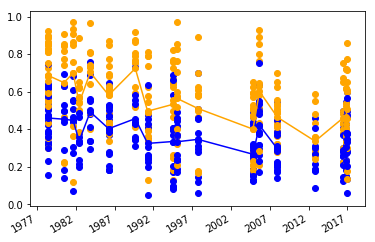

In [90]:
fig, ax = plt.subplots()
ax.plot_date(stones_df['release_date'].values, stones_df['complexity'].values, linestyle='-', color='blue')
ax.plot_date(stones_df['release_date'].values, stones_df['valence'].values, linestyle='-', color='orange')

fig.autofmt_xdate()

for a in stones_df.itertuples():
    for t in tracks.find({'album.id': a[1], 'complexity': {'$exists': True}}):
        ax.scatter(a.release_date, t['complexity'], color='blue')
        ax.scatter(a.release_date, t['valence'], color='orange')

plt.show()

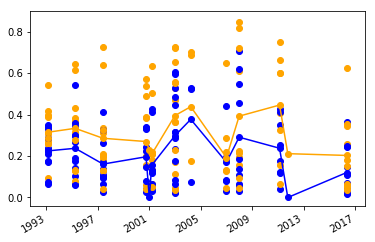

In [91]:
fig, ax = plt.subplots()
ax.plot_date(radiohead_df['release_date'].values, radiohead_df['complexity'].values, linestyle='-', color='blue')
ax.plot_date(radiohead_df['release_date'].values, radiohead_df['valence'].values, linestyle='-', color='orange')

fig.autofmt_xdate()

for a in radiohead_df.itertuples():
    for t in tracks.find({'album.id': a[1], 'complexity': {'$exists': True}}):
        ax.scatter(a.release_date, t['complexity'], color='blue')
        ax.scatter(a.release_date, t['valence'], color='orange')

plt.show()

It definitely looks like the Beatles changed style over time, with the _White Ablum_ / _Yellow Submarine_ (around 1969) being a glitch in the trend. _Hail to the Thief_ and _Com Lag_ are unusual albums for Radiohead.

# Conclusion<a name="conclusion"></a>
A couple of things have come out of this. 

One is that the original analysis is very sensitive to how the sentiment of lyrics is determined. That means I'm not too confident about the reliability of results from either fitteR-happieR or this notebook.

Another is that the Beatles are undoubtedly better than Radiohead. The happiest Beatles sonds are happier than anything Radiohead have done, and their saddest songs are about as sad as Radiohead. In just about every measure, the Beatles' range of music is larger, and covers, Radiohead's.

QED.

## Next steps
The obvious next step is to analyse a different group. What would Queen or ELO look like? Is Adele more depressing than Radiohead?

Another approach would be to apply some machine learning / data mining techniques, perhaps to train a better sentiment analyser, or to cluster songs into groups. Which songs by different artists are most similar to each other?

* [Top](#top)